Import Libraries and Fetch Dataset


In [1]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
from sklearn.metrics import mean_absolute_error

# Fetch the dataset
energy_efficiency = fetch_ucirepo(id=242)

# Data (as pandas dataframes)
X = energy_efficiency.data.features
y = energy_efficiency.data.targets

# Rename the columns based on dataset description
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
             'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']

# Select input features
inputs = X[['Relative Compactness', 'Surface Area', 'Wall Area', 'Glazing Area']]

# Select output targets
outputs = y[['Heating Load', 'Cooling Load']]

# Display the selected inputs and outputs
print("\nSelected Inputs:")
print(inputs.head())
print("\nSelected Outputs:")
print(outputs.head())



Selected Inputs:
   Relative Compactness  Surface Area  Wall Area  Glazing Area
0                  0.98         514.5      294.0           0.0
1                  0.98         514.5      294.0           0.0
2                  0.98         514.5      294.0           0.0
3                  0.98         514.5      294.0           0.0
4                  0.90         563.5      318.5           0.0

Selected Outputs:
   Heating Load  Cooling Load
0         15.55         21.33
1         15.55         21.33
2         15.55         21.33
3         15.55         21.33
4         20.84         28.28


Define Fuzzy Variables and Membership Functions


In [2]:
# Define fuzzy variables for inputs
relative_compactness = ctrl.Antecedent(np.arange(0.62, 0.99, 0.01), 'relative_compactness')
surface_area = ctrl.Antecedent(np.arange(514.5, 808.6, 1), 'surface_area')
wall_area = ctrl.Antecedent(np.arange(245.0, 416.6, 1), 'wall_area')
glazing_area = ctrl.Antecedent(np.arange(0.0, 0.41, 0.01), 'glazing_area')

# Define fuzzy variables for outputs
heating_load = ctrl.Consequent(np.arange(6.0, 43.1, 0.1), 'heating_load')
cooling_load = ctrl.Consequent(np.arange(10.9, 48.1, 0.1), 'cooling_load')

# Membership Functions for Inputs
# Relative Compactness
relative_compactness['low'] = fuzz.trimf(relative_compactness.universe, [0.62, 0.62, 0.75])
relative_compactness['medium'] = fuzz.trimf(relative_compactness.universe, [0.62, 0.75, 0.89])
relative_compactness['high'] = fuzz.trimf(relative_compactness.universe, [0.75, 0.89, 0.98])

# Surface Area
surface_area['small'] = fuzz.trimf(surface_area.universe, [514.5, 514.5, 661.5])
surface_area['medium'] = fuzz.trimf(surface_area.universe, [514.5, 661.5, 808.5])
surface_area['large'] = fuzz.trimf(surface_area.universe, [661.5, 808.5, 808.5])

# Wall Area
wall_area['small'] = fuzz.trimf(wall_area.universe, [245.0, 245.0, 330.0])
wall_area['medium'] = fuzz.trimf(wall_area.universe, [245.0, 330.0, 416.5])
wall_area['large'] = fuzz.trimf(wall_area.universe, [330.0, 416.5, 416.5])

# Glazing Area
glazing_area['none'] = fuzz.trimf(glazing_area.universe, [0.0, 0.0, 0.1])
glazing_area['low'] = fuzz.trimf(glazing_area.universe, [0.0, 0.1, 0.25])
glazing_area['high'] = fuzz.trimf(glazing_area.universe, [0.1, 0.25, 0.4])

# Membership Functions for Outputs
# Heating Load
heating_load['low'] = fuzz.trimf(heating_load.universe, [6.0, 6.0, 20.0])
heating_load['medium'] = fuzz.trimf(heating_load.universe, [6.0, 20.0, 34.0])
heating_load['high'] = fuzz.trimf(heating_load.universe, [20.0, 34.0, 43.1])

# Cooling Load
cooling_load['low'] = fuzz.trimf(cooling_load.universe, [10.9, 10.9, 25.0])
cooling_load['medium'] = fuzz.trimf(cooling_load.universe, [10.9, 25.0, 39.0])
cooling_load['high'] = fuzz.trimf(cooling_load.universe, [25.0, 39.0, 48.1])


Visualize Membership Functions


c:\Users\abhis\OneDrive\Desktop\AML\task2\task2\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


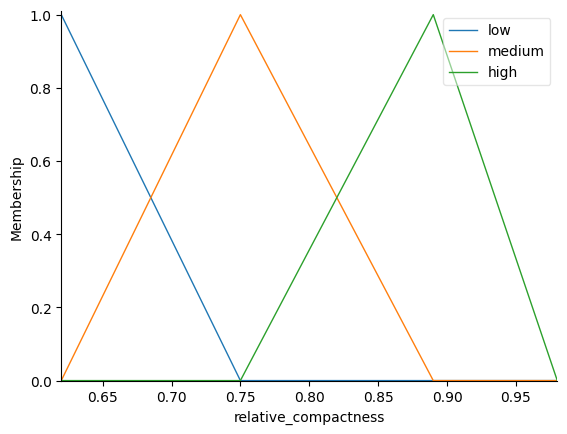

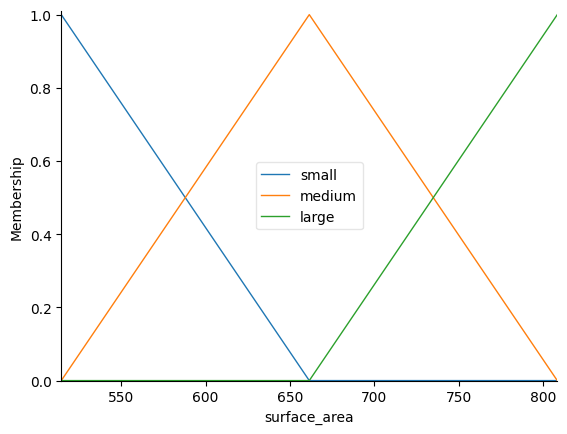

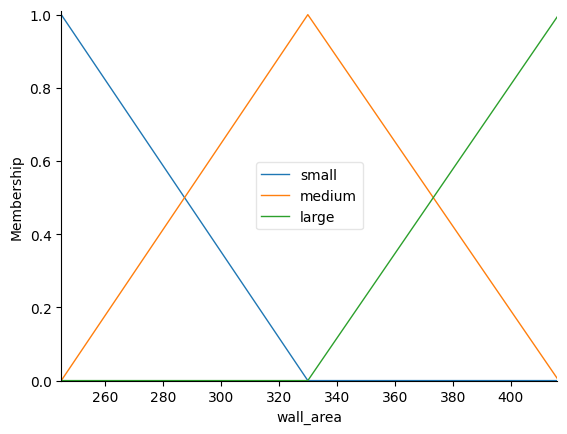

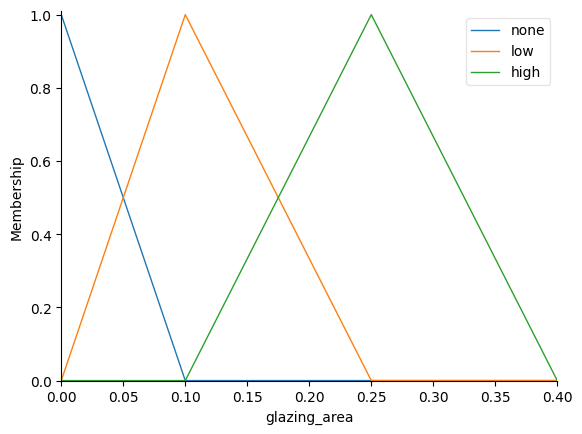

In [3]:
# Visualize input membership functions
%matplotlib inline
relative_compactness.view()
surface_area.view()
wall_area.view()
glazing_area.view()


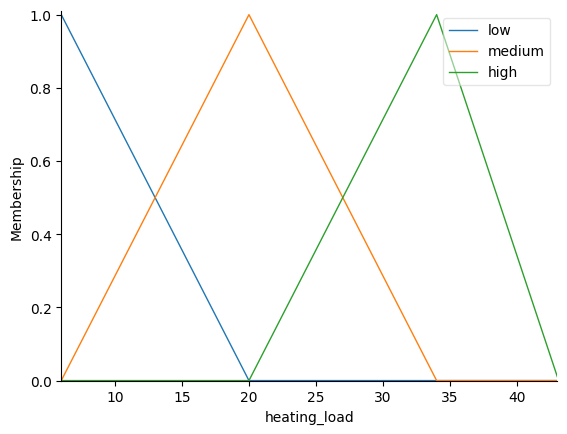

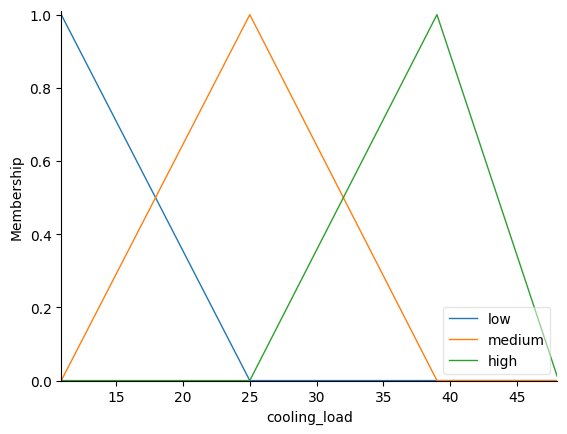

In [4]:
# Visualize output membership functions
heating_load.view()
cooling_load.view()


Define Fuzzy Rules and Control Systems


In [5]:
# Define fuzzy rules
rule1 = ctrl.Rule(relative_compactness['low'] & surface_area['large'], heating_load['high'])
rule2 = ctrl.Rule(relative_compactness['medium'] & wall_area['medium'], heating_load['medium'])
rule3 = ctrl.Rule(glazing_area['high'], cooling_load['high'])
rule4 = ctrl.Rule(glazing_area['none'], cooling_load['low'])
rule5 = ctrl.Rule(surface_area['small'] & wall_area['small'], heating_load['low'])
rule6 = ctrl.Rule(relative_compactness['high'] & glazing_area['low'], cooling_load['medium'])

# Control system for heating load
heating_ctrl = ctrl.ControlSystem([rule1, rule2, rule5])

# Control system for cooling load
cooling_ctrl = ctrl.ControlSystem([rule3, rule4, rule6])

# Create simulation objects
heating_simulation = ctrl.ControlSystemSimulation(heating_ctrl)
cooling_simulation = ctrl.ControlSystemSimulation(cooling_ctrl)


Evaluate the FLC on the Dataset


In [6]:
# Lists to store predicted loads
predicted_heating_load = []
predicted_cooling_load = []

# Loop over each sample in the dataset
for index, row in inputs.iterrows():
    # Heating simulation inputs
    heating_simulation.input['relative_compactness'] = row['Relative Compactness']
    heating_simulation.input['surface_area'] = row['Surface Area']
    heating_simulation.input['wall_area'] = row['Wall Area']
    
    # Compute heating load
    try:
        heating_simulation.compute()
        predicted_heating_load.append(heating_simulation.output['heating_load'])
    except:
        predicted_heating_load.append(np.nan)
    
    # Cooling simulation inputs
    cooling_simulation.input['glazing_area'] = row['Glazing Area']
    cooling_simulation.input['relative_compactness'] = row['Relative Compactness']
    
    # Compute cooling load
    try:
        cooling_simulation.compute()
        predicted_cooling_load.append(cooling_simulation.output['cooling_load'])
    except:
        predicted_cooling_load.append(np.nan)

# Add predictions to the outputs dataframe
outputs['Predicted Heating Load'] = predicted_heating_load
outputs['Predicted Cooling Load'] = predicted_cooling_load

# Remove NaN values
outputs_clean = outputs.dropna()

# Calculate MAE for heating load
heating_mae = mean_absolute_error(outputs_clean['Heating Load'], outputs_clean['Predicted Heating Load'])
print(f"Heating Load MAE: {heating_mae:.2f}")

# Calculate MAE for cooling load
cooling_mae = mean_absolute_error(outputs_clean['Cooling Load'], outputs_clean['Predicted Cooling Load'])
print(f"Cooling Load MAE: {cooling_mae:.2f}")


Heating Load MAE: 14.31
Cooling Load MAE: 10.26


Set Up the Genetic Algorithm


In [7]:
import warnings
warnings.filterwarnings('ignore')

# Ensure creator classes are not recreated
if 'FitnessMin' not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize the MAE
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Define the individual creation function with ordering constraints
def create_individual():
    rc_low_end = random.uniform(0.62, 0.75)
    rc_medium_center = random.uniform(rc_low_end, 0.89)
    rc_high_start = random.uniform(rc_medium_center, 0.98)
    individual = creator.Individual([rc_low_end, rc_medium_center, rc_high_start])
    return individual

toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Repair function to enforce constraints
def repair_individual(individual):
    individual.sort()
    individual[0] = max(min(individual[0], 0.75), 0.62)
    individual[1] = max(min(individual[1], 0.89), individual[0])
    individual[2] = max(min(individual[2], 0.98), individual[1])

# Mutation function that maintains ordering constraints
def mutate_individual(individual, indpb=0.2):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] += random.gauss(0, 0.01)
    repair_individual(individual)
    return (individual,)

toolbox.register("mutate", mutate_individual)

# Crossover function that maintains ordering constraints
def mate_individuals(ind1, ind2):
    child1, child2 = tools.cxBlend(ind1, ind2, alpha=0.5)
    child1 = creator.Individual(child1)
    child2 = creator.Individual(child2)
    repair_individual(child1)
    repair_individual(child2)
    return (child1, child2)

toolbox.register("mate", mate_individuals)

toolbox.register("select", tools.selTournament, tournsize=3)

# Define the fitness function
def evaluate(individual):
    # Extract parameter values
    rc_low_end = individual[0]
    rc_medium_center = individual[1]
    rc_high_start = individual[2]
    
    # Check constraints
    if not (0.62 <= rc_low_end <= rc_medium_center <= rc_high_start <= 0.98):
        return (float('inf'),)
    
    # Update membership functions with new parameters
    try:
        relative_compactness['low'] = fuzz.trimf(relative_compactness.universe, [0.62, 0.62, rc_low_end])
        relative_compactness['medium'] = fuzz.trimf(relative_compactness.universe, [rc_low_end, rc_medium_center, rc_high_start])
        relative_compactness['high'] = fuzz.trimf(relative_compactness.universe, [rc_high_start, 0.98, 0.98])
    except AssertionError:
        return (float('inf'),)
    
    # Re-create the control systems with updated membership functions
    # Define fuzzy rules (need to be redefined due to updated membership functions)
    rule1_e = ctrl.Rule(relative_compactness['low'] & surface_area['large'], heating_load['high'])
    rule2_e = ctrl.Rule(relative_compactness['medium'] & wall_area['medium'], heating_load['medium'])
    rule5_e = ctrl.Rule(surface_area['small'] & wall_area['small'], heating_load['low'])
    heating_ctrl_e = ctrl.ControlSystem([rule1_e, rule2_e, rule5_e])
    heating_simulation = ctrl.ControlSystemSimulation(heating_ctrl_e)
    
    rule3_e = ctrl.Rule(glazing_area['high'], cooling_load['high'])
    rule4_e = ctrl.Rule(glazing_area['none'], cooling_load['low'])
    rule6_e = ctrl.Rule(relative_compactness['high'] & glazing_area['low'], cooling_load['medium'])
    cooling_ctrl_e = ctrl.ControlSystem([rule3_e, rule4_e, rule6_e])
    cooling_simulation = ctrl.ControlSystemSimulation(cooling_ctrl_e)
    
    # Lists to store predicted loads
    predicted_heating_load = []
    predicted_cooling_load = []
    
    # Loop over a subset of the dataset to save time
    sample_indices = inputs.sample(n=100, random_state=42).index
    for index in sample_indices:
        row = inputs.loc[index]
        # Heating simulation inputs
        heating_simulation.input['relative_compactness'] = row['Relative Compactness']
        heating_simulation.input['surface_area'] = row['Surface Area']
        heating_simulation.input['wall_area'] = row['Wall Area']
        
        # Compute heating load
        try:
            heating_simulation.compute()
            predicted_heating_load.append(heating_simulation.output['heating_load'])
        except:
            predicted_heating_load.append(np.nan)
        
        # Cooling simulation inputs
        cooling_simulation.input['glazing_area'] = row['Glazing Area']
        cooling_simulation.input['relative_compactness'] = row['Relative Compactness']
        
        # Compute cooling load
        try:
            cooling_simulation.compute()
            predicted_cooling_load.append(cooling_simulation.output['cooling_load'])
        except:
            predicted_cooling_load.append(np.nan)
    
    # Prepare outputs
    outputs_sample = outputs.loc[sample_indices]
    outputs_sample = outputs_sample.copy()
    outputs_sample['Predicted Heating Load'] = predicted_heating_load
    outputs_sample['Predicted Cooling Load'] = predicted_cooling_load
    
    # Remove NaN values
    outputs_clean = outputs_sample.dropna()
    
    if outputs_clean.empty:
        return (float('inf'),)
    
    # Calculate MAE for heating and cooling loads
    heating_mae = mean_absolute_error(outputs_clean['Heating Load'], outputs_clean['Predicted Heating Load'])
    cooling_mae = mean_absolute_error(outputs_clean['Cooling Load'], outputs_clean['Predicted Cooling Load'])
    
    # Total error
    total_mae = heating_mae + cooling_mae
    
    # Return the fitness value (to be minimized)
    return (total_mae,)

toolbox.register("evaluate", evaluate)


Run the Genetic Algorithm


In [8]:
# Initialize the population
population = toolbox.population(n=20)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", lambda fits: np.mean([f for f in fits if np.isfinite(f)]) if any(np.isfinite(f) for f in fits) else float('inf'))
stats.register("min", lambda fits: np.min([f for f in fits if np.isfinite(f)]) if any(np.isfinite(f) for f in fits) else float('inf'))

# Run the genetic algorithm
num_generations = 10
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2,
                                          ngen=num_generations, stats=stats, verbose=True)


gen	nevals	avg    	min    
0  	0     	25.9261	23.0146
1  	13    	24.8007	22.5464
2  	15    	23.5903	22.6076
3  	17    	23.0953	22.5399
4  	13    	22.6842	22.5359
5  	14    	22.6908	22.534 
6  	20    	22.662 	22.5333
7  	18    	22.5358	22.5333
8  	15    	22.5934	22.5322
9  	12    	22.5337	22.5322
10 	12    	22.5914	22.5322


Extract and Apply the Best Individual



Best Individual Parameters:
rc_low_end: 0.6357
rc_medium_center: 0.8820
rc_high_start: 0.9356

Best Fitness (Total MAE): 22.53


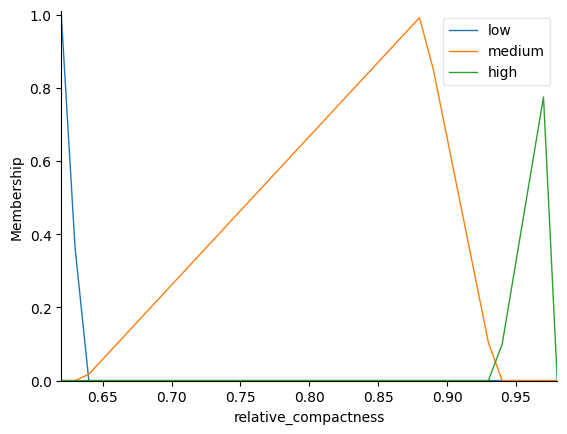

In [9]:
# Get the best individual with finite fitness
valid_individuals = [ind for ind in population if np.isfinite(ind.fitness.values[0])]
if valid_individuals:
    best_individual = tools.selBest(valid_individuals, k=1)[0]
    print("\nBest Individual Parameters:")
    for i, param_name in enumerate(['rc_low_end', 'rc_medium_center', 'rc_high_start']):
        print(f"{param_name}: {best_individual[i]:.4f}")

    print(f"\nBest Fitness (Total MAE): {best_individual.fitness.values[0]:.2f}")

    # Update membership functions with optimized parameters
    rc_low_end = best_individual[0]
    rc_medium_center = best_individual[1]
    rc_high_start = best_individual[2]

    relative_compactness['low'] = fuzz.trimf(relative_compactness.universe, [0.62, 0.62, rc_low_end])
    relative_compactness['medium'] = fuzz.trimf(relative_compactness.universe, [rc_low_end, rc_medium_center, rc_high_start])
    relative_compactness['high'] = fuzz.trimf(relative_compactness.universe, [rc_high_start, 0.98, 0.98])

    # Visualize the updated membership functions
    relative_compactness.view()
else:
    print("No valid individuals found.")


Evaluate the Optimized FLC


In [10]:
if valid_individuals:
    # Re-create the control systems with updated membership functions
    rule1 = ctrl.Rule(relative_compactness['low'] & surface_area['large'], heating_load['high'])
    rule2 = ctrl.Rule(relative_compactness['medium'] & wall_area['medium'], heating_load['medium'])
    rule5 = ctrl.Rule(surface_area['small'] & wall_area['small'], heating_load['low'])
    heating_ctrl = ctrl.ControlSystem([rule1, rule2, rule5])
    heating_simulation = ctrl.ControlSystemSimulation(heating_ctrl)

    rule3 = ctrl.Rule(glazing_area['high'], cooling_load['high'])
    rule4 = ctrl.Rule(glazing_area['none'], cooling_load['low'])
    rule6 = ctrl.Rule(relative_compactness['high'] & glazing_area['low'], cooling_load['medium'])
    cooling_ctrl = ctrl.ControlSystem([rule3, rule4, rule6])
    cooling_simulation = ctrl.ControlSystemSimulation(cooling_ctrl)

    # Lists to store predicted loads
    predicted_heating_load_opt = []
    predicted_cooling_load_opt = []

    # Loop over each sample in the dataset
    for index, row in inputs.iterrows():
        # Heating simulation inputs
        heating_simulation.input['relative_compactness'] = row['Relative Compactness']
        heating_simulation.input['surface_area'] = row['Surface Area']
        heating_simulation.input['wall_area'] = row['Wall Area']
        
        # Compute heating load
        try:
            heating_simulation.compute()
            predicted_heating_load_opt.append(heating_simulation.output['heating_load'])
        except:
            predicted_heating_load_opt.append(np.nan)
        
        # Cooling simulation inputs
        cooling_simulation.input['glazing_area'] = row['Glazing Area']
        cooling_simulation.input['relative_compactness'] = row['Relative Compactness']
        
        # Compute cooling load
        try:
            cooling_simulation.compute()
            predicted_cooling_load_opt.append(cooling_simulation.output['cooling_load'])
        except:
            predicted_cooling_load_opt.append(np.nan)
    
    # Add optimized predictions to the outputs dataframe
    outputs['Predicted Heating Load Opt'] = predicted_heating_load_opt
    outputs['Predicted Cooling Load Opt'] = predicted_cooling_load_opt
    
    # Remove NaN values
    outputs_clean_opt = outputs.dropna()
    
    # Check if outputs_clean_opt is empty
    if outputs_clean_opt.empty:
        print("\nNo valid predictions after optimization.")
    else:
        # Calculate MAE for heating and cooling loads
        heating_mae_opt = mean_absolute_error(outputs_clean_opt['Heating Load'], outputs_clean_opt['Predicted Heating Load Opt'])
        cooling_mae_opt = mean_absolute_error(outputs_clean_opt['Cooling Load'], outputs_clean_opt['Predicted Cooling Load Opt'])
        
        print(f"\nOptimized Heating Load MAE: {heating_mae_opt:.2f}")
        print(f"Optimized Cooling Load MAE: {cooling_mae_opt:.2f}")
else:
    print("Cannot evaluate optimized FLC as no valid individuals were found.")



Optimized Heating Load MAE: 10.49
Optimized Cooling Load MAE: 10.45


Compare Before and After Optimization


In [11]:
if valid_individuals and not outputs_clean_opt.empty:
    print(f"\nImprovement in Heating Load MAE: {heating_mae - heating_mae_opt:.2f}")
    print(f"Improvement in Cooling Load MAE: {cooling_mae - cooling_mae_opt:.2f}")



Improvement in Heating Load MAE: 3.81
Improvement in Cooling Load MAE: -0.19


Plot the Results


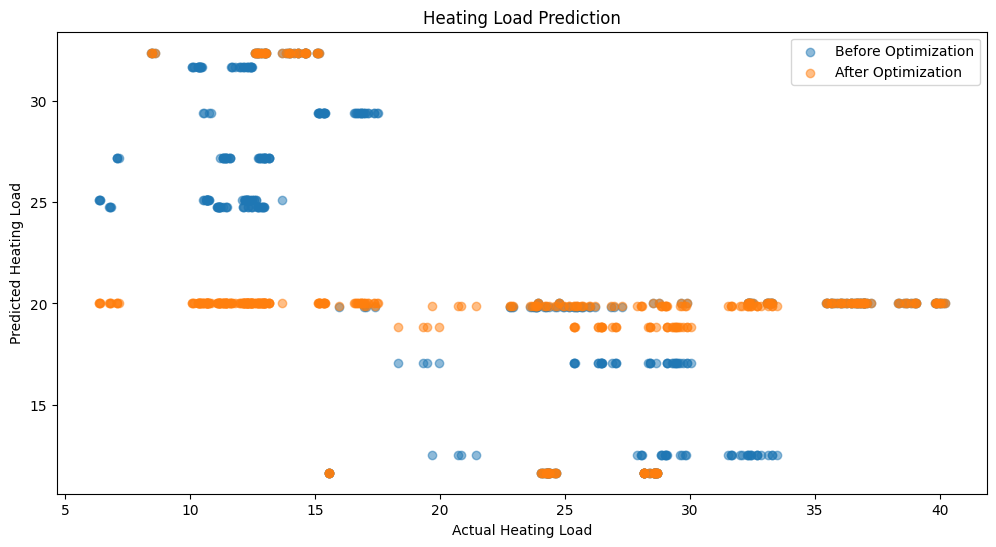

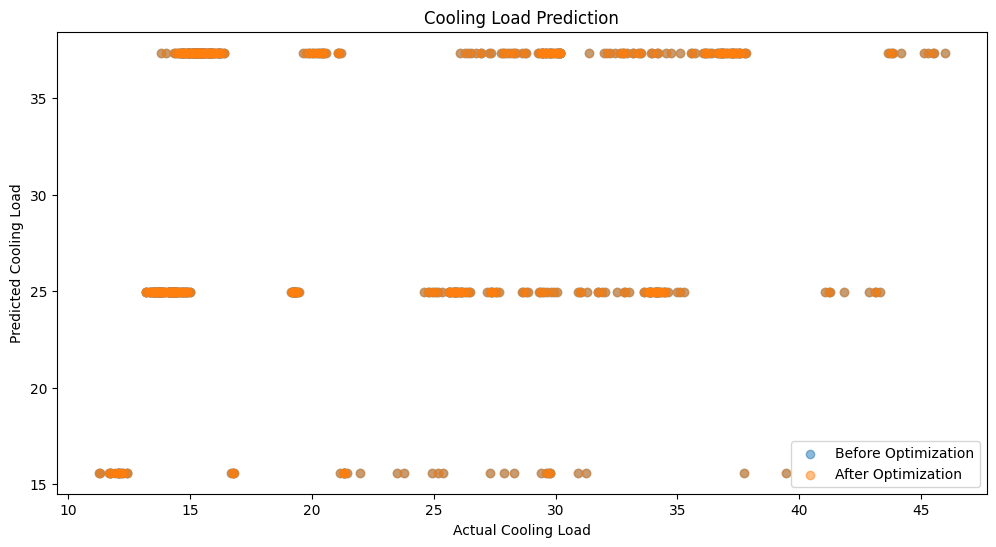

In [12]:
if valid_individuals and not outputs_clean_opt.empty:
    # Plot actual vs predicted heating load before and after optimization
    plt.figure(figsize=(12, 6))
    plt.scatter(outputs_clean_opt['Heating Load'], outputs_clean_opt['Predicted Heating Load'], label='Before Optimization', alpha=0.5)
    plt.scatter(outputs_clean_opt['Heating Load'], outputs_clean_opt['Predicted Heating Load Opt'], label='After Optimization', alpha=0.5)
    plt.xlabel('Actual Heating Load')
    plt.ylabel('Predicted Heating Load')
    plt.legend()
    plt.title('Heating Load Prediction')
    plt.show()
    
    # Plot actual vs predicted cooling load before and after optimization
    plt.figure(figsize=(12, 6))
    plt.scatter(outputs_clean_opt['Cooling Load'], outputs_clean_opt['Predicted Cooling Load'], label='Before Optimization', alpha=0.5)
    plt.scatter(outputs_clean_opt['Cooling Load'], outputs_clean_opt['Predicted Cooling Load Opt'], label='After Optimization', alpha=0.5)
    plt.xlabel('Actual Cooling Load')
    plt.ylabel('Predicted Cooling Load')
    plt.legend()
    plt.title('Cooling Load Prediction')
    plt.show()


In [30]:
# Cell 15: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import pyswarms as ps
import random
import warnings
warnings.filterwarnings("ignore")


In [32]:
# Define Benchmark Functions

# Shifted Sphere Function
def shifted_sphere(x, o):
    return np.sum((x - o) ** 2)

# Shifted Rastrigin's Function
def shifted_rastrigin(x, o):
    return np.sum((x - o) ** 2 - 10 * np.cos(2 * np.pi * (x - o)) + 10)


In [33]:
# Set Up Experiment Parameters

# Experiment parameters
num_runs = 15
dimensions = [2, 10]
functions = [shifted_sphere, shifted_rastrigin]
function_names = ['Shifted Sphere', 'Shifted Rastrigin']
algorithm_names = ['GA', 'PSO']  # Renamed to avoid conflict with deap.algorithms

# Variable bounds
lower_bound = -5.12
upper_bound = 5.12


In [35]:
#Run Experiments

# Initialize results dictionary
results = {}

for func, func_name in zip(functions, function_names):
    results[func_name] = {}
    for D in dimensions:
        print(f'Running experiments for {func_name} with D = {D}')
        # Generate shift vector o
        o = np.random.uniform(lower_bound, upper_bound, D)
        results[func_name][f'D={D}'] = {}
        
        # Bounds for the optimizer
        bounds = (np.array([lower_bound]*D), np.array([upper_bound]*D))
        
        # Storage for results
        ga_results = []
        pso_results = []
        
        # Define objective functions
        # For GA, DEAP expects the fitness function to return a tuple
        def ga_fitness(individual):
            x = np.array(individual)
            return (func(x, o),)
        
        # For PSO, PySwarms expects a function that operates on a 2D array
        def pso_fitness(x):
            # x is a 2D array of shape (n_particles, dimensions)
            n_particles = x.shape[0]
            fitness = np.zeros(n_particles)
            for i in range(n_particles):
                fitness[i] = func(x[i], o)
            return fitness
        
        # Run GA
        ga_results = []
        for run in range(num_runs):
            # Set up GA using DEAP
            # Create Fitness and Individual classes
            if 'FitnessMin' in creator.__dict__:
                del creator.FitnessMin
            if 'Individual' in creator.__dict__:
                del creator.Individual
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
            creator.create("Individual", list, fitness=creator.FitnessMin)
            
            toolbox = base.Toolbox()
            # Attribute generator
            toolbox.register("attr_float", random.uniform, lower_bound, upper_bound)
            # Structure initializers
            toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, D)
            toolbox.register("population", tools.initRepeat, list, toolbox.individual)
            # Register the evaluation function
            toolbox.register("evaluate", ga_fitness)
            # Register genetic operators
            toolbox.register("mate", tools.cxBlend, alpha=0.5)
            toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
            toolbox.register("select", tools.selTournament, tournsize=3)
            
            # Initialize population
            pop = toolbox.population(n=50)
            # Run GA
            algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, verbose=False)
            # Get the best individual
            best_ind = tools.selBest(pop, 1)[0]
            best_fitness = best_ind.fitness.values[0]
            ga_results.append(best_fitness)
            
            # Clean up DEAP creators to prevent errors
            del creator.FitnessMin
            del creator.Individual
        
        # Run PSO
        pso_results = []
        for run in range(num_runs):
            options = {'c1': 1.49445, 'c2': 1.49445, 'w': 0.729}
            optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=D, options=options, bounds=bounds)
            # Run optimization
            best_cost, _ = optimizer.optimize(pso_fitness, iters=100, verbose=False)
            pso_results.append(best_cost)
        
        # Store results
        results[func_name][f'D={D}']['GA'] = ga_results
        results[func_name][f'D={D}']['PSO'] = pso_results


Running experiments for Shifted Sphere with D = 2
Running experiments for Shifted Sphere with D = 10
Running experiments for Shifted Rastrigin with D = 2
Running experiments for Shifted Rastrigin with D = 10


In [36]:
#Analyze and Report Results

for func_name in function_names:
    print(f'\nFunction: {func_name}')
    for D in dimensions:
        print(f'Dimension: {D}')
        for algo in algorithm_names:
            # Retrieve results
            values = results[func_name][f'D={D}'][algo]
            avg = np.mean(values)
            std_dev = np.std(values)
            best = np.min(values)
            worst = np.max(values)
            print(f'Algorithm: {algo}')
            print(f'Average Best Value: {avg:.6e}')
            print(f'Standard Deviation: {std_dev:.6e}')
            print(f'Best Value: {best:.6e}')
            print(f'Worst Value: {worst:.6e}\n')



Function: Shifted Sphere
Dimension: 2
Algorithm: GA
Average Best Value: 1.567439e-07
Standard Deviation: 5.320027e-07
Best Value: 0.000000e+00
Worst Value: 2.137338e-06

Algorithm: PSO
Average Best Value: 2.898327e-12
Standard Deviation: 7.040408e-12
Best Value: 2.513901e-14
Worst Value: 2.898969e-11

Dimension: 10
Algorithm: GA
Average Best Value: 1.205502e-04
Standard Deviation: 1.832879e-04
Best Value: 3.018427e-07
Worst Value: 5.595694e-04

Algorithm: PSO
Average Best Value: 6.158268e+00
Standard Deviation: 3.426575e+00
Best Value: 2.397542e+00
Worst Value: 1.640909e+01


Function: Shifted Rastrigin
Dimension: 2
Algorithm: GA
Average Best Value: 7.960084e-01
Standard Deviation: 1.268952e+00
Best Value: 0.000000e+00
Worst Value: 4.974790e+00

Algorithm: PSO
Average Best Value: 7.904053e-08
Standard Deviation: 2.318863e-07
Best Value: 8.983037e-12
Worst Value: 9.410780e-07

Dimension: 10
Algorithm: GA
Average Best Value: 2.065792e+01
Standard Deviation: 1.191942e+01
Best Value: 5.96

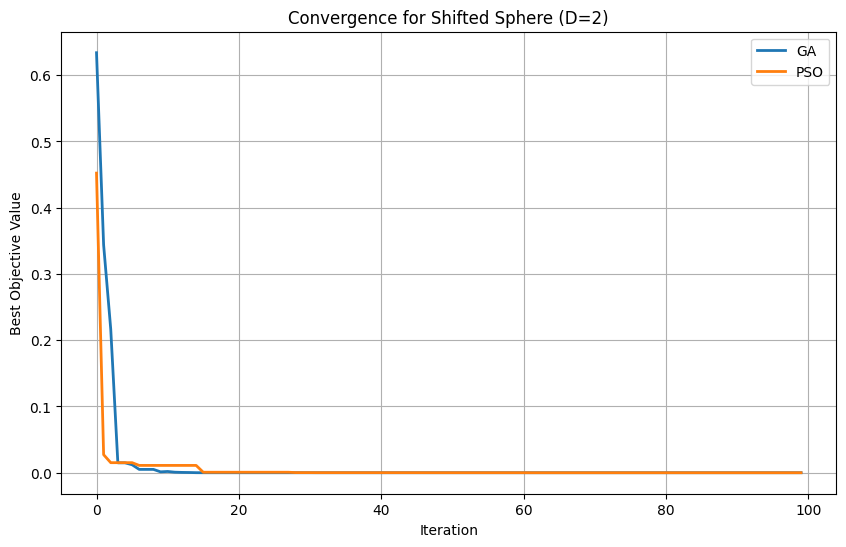

In [37]:
# Cell 20: Plot Convergence Graphs (Optional)

# Choose one function and dimension to plot
func = shifted_sphere
func_name = 'Shifted Sphere'
D = 2
o = np.random.uniform(lower_bound, upper_bound, D)
bounds = (np.array([lower_bound]*D), np.array([upper_bound]*D))

# For GA
def ga_fitness(individual):
    x = np.array(individual)
    return (func(x, o),)

# For PSO
def pso_fitness(x):
    n_particles = x.shape[0]
    fitness = np.zeros(n_particles)
    for i in range(n_particles):
        fitness[i] = func(x[i], o)
    return fitness

# Run GA and record convergence
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, lower_bound, upper_bound)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, D)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga_fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

ga_log = []
def record_ga_stats(generation):
    best = tools.selBest(pop, 1)[0]
    ga_log.append(best.fitness.values[0])

for gen in range(100):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))
    record_ga_stats(gen)

del creator.FitnessMin
del creator.Individual

# Run PSO and record convergence
options = {'c1': 1.49445, 'c2': 1.49445, 'w': 0.729}
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=D, options=options, bounds=bounds)
cost, pos = optimizer.optimize(pso_fitness, iters=100, verbose=False)
pso_log = optimizer.cost_history

# Plot convergence
plt.figure(figsize=(10,6))
plt.plot(ga_log, label='GA', linewidth=2)
plt.plot(pso_log, label='PSO', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value')
plt.title(f'Convergence for {func_name} (D={D})')
plt.legend()
plt.grid(True)
plt.show()
